# Who's a better batter: Mike Piazza or Hank Aaron?

## Let's look at the data

In [230]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20,12]
plt.style.use('fivethirtyeight')

from scipy.stats import beta
from scipy import special
import numpy as np

In [5]:
df_BA = pd.read_csv('df_BA.csv', index_col = 0)

In [6]:
df_BA[df_BA['Name'].isin(['Hank Aaron', 'Mike Piazza'])]

,playerID,Name,AB,H,average,Empirical Bayes Estimate,alpha1,beta1,PEP,Cumulative Mean
6773,piazzmi01,Mike Piazza,6911,2127,0.307770,0.305543,2244.983578,5102.546789,0.151123,0.035985
0,aaronha01,Hank Aaron,12364,3771,0.304998,0.303814,3888.983578,8911.546789,0.174112,0.042664


### Mike Piazza has a higher naive batting average and a higher posterior (empirical bayes) batting average

### But Hank Aaron's are very close, and he has almost twice as many at bats

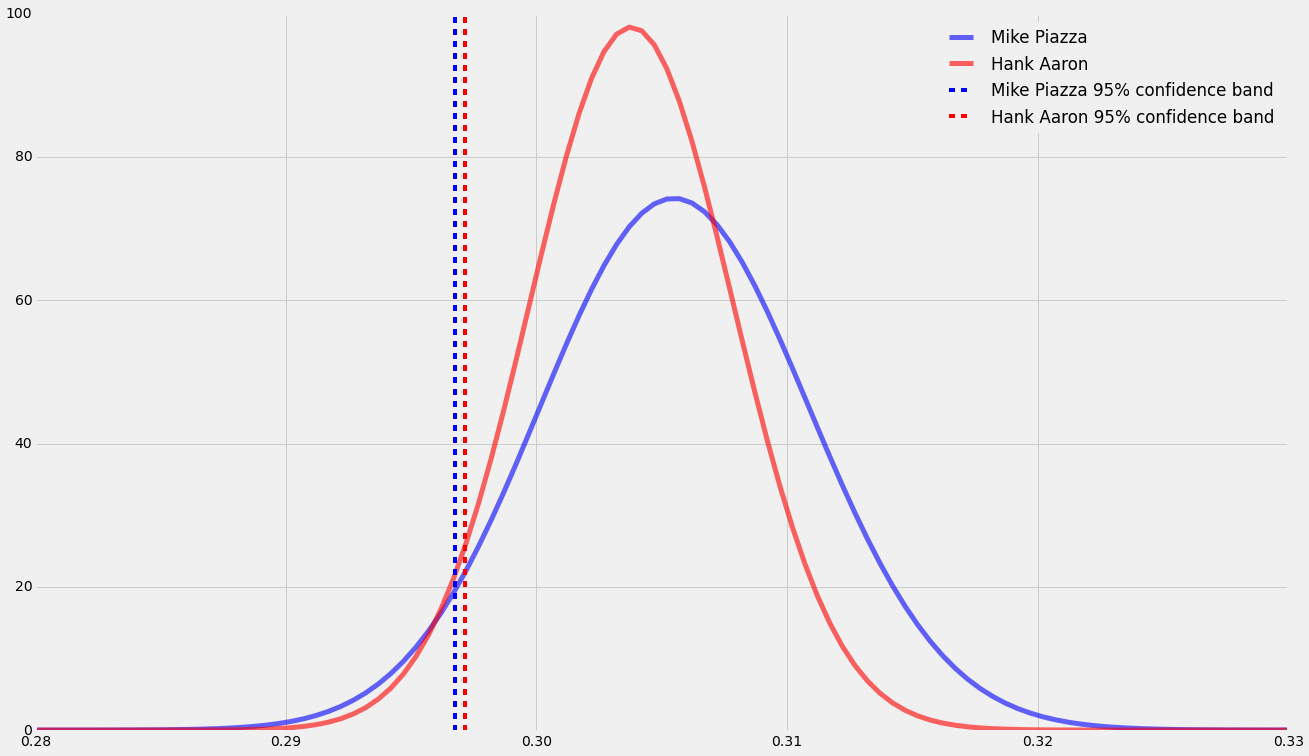

In [179]:
x = np.linspace(0.1,0.6,1000)

#plotting the posterior beta distributions for the first 5 players
a_MP = df_BA[df_BA['Name']=='Mike Piazza']['alpha1'].values[0]
b_MP = df_BA[df_BA['Name']=='Mike Piazza']['beta1'].values[0]

a_HA = df_BA[df_BA['Name']=='Hank Aaron']['alpha1'].values[0]
b_HA = df_BA[df_BA['Name']=='Hank Aaron']['beta1'].values[0]

plt.plot(x, beta.pdf(x, a_MP, b_MP),lw=5, alpha=0.6, color = 'b', label='Mike Piazza')
plt.plot(x, beta.pdf(x, a_HA, b_HA),lw=5, alpha=0.6, color = 'r', label='Hank Aaron')

v_low_MP = beta.ppf(0.05, a_MP, b_MP)
v_low_HA = beta.ppf(0.05, a_HA, b_HA)

plt.axvline(v_low_MP, ls = 'dashed', color = 'b', label = 'Mike Piazza 95% confidence band')
plt.axvline(v_low_HA, ls = 'dashed', color = 'r', label = 'Hank Aaron 95% confidence band')

plt.ylim([-0.1, 100])
plt.xlim([0.28, 0.33])
plt.legend()
plt.show()

### From the chart above, we can see that Mike Piazza has a higher average, but a wider distribution and a lower 95% confidence band

# There are 4 ways to determine who is the better player:
### 1. Simulation of posterior draws
### 2. Numerical integration
### 3. Closed-form solution
### 4. Closed-form approximation

____

# 1. Simulation of posterior draws

- take N random samples from each distribution, and compare them

In [32]:
MP_draws = np.random.beta(a_MP, b_MP, size = 100000)
HA_draws = np.random.beta(a_HA, b_HA, size = 100000)
df_comparison = pd.DataFrame({'Mike Piazza':MP_draws,
                             'Hank Aaron': HA_draws})
df_comparison['MP flag'] = (df_comparison['Mike Piazza']>df_comparison['Hank Aaron']).astype(int)
df_comparison['HA flag'] = (df_comparison['Mike Piazza']<df_comparison['Hank Aaron']).astype(int)

In [33]:
df_comparison.head()

,Hank Aaron,Mike Piazza,MP flag,HA flag
0,0.306210,0.304297,0,1
1,0.302171,0.310618,1,0
2,0.310192,0.302859,0,1
3,0.301359,0.307561,1,0
4,0.307707,0.308530,1,0


In [34]:
df_comparison[['MP flag', 'HA flag']].sum(), df_comparison['MP flag'].sum()/float(100000)

(MP flag    59976
 HA flag    40024
 dtype: int64, 0.59975999999999996)

## So in 59,976 of the 100,000 simulations (59.98%), Mike Piazza had the higher drawn value

### Most of the time, this result would be sufficient to say that Mike Piazza has the higher "real" batting average

# 2. Numerical Integration

- this is another brute force solution
    - start with a scatter plot of the beta dist'n values for Aaron and Piazza
    
    
### First, consider the joint distribution function for the two players

In [106]:
x = np.linspace(0.29,0.33,5000)

f = lambda x, y: beta.pdf(x, a_MP, b_MP)*beta.pdf(y, a_HA, b_HA)#*(1/5000**2)

X, Y = np.meshgrid(x, x)
Z = f(X, Y)

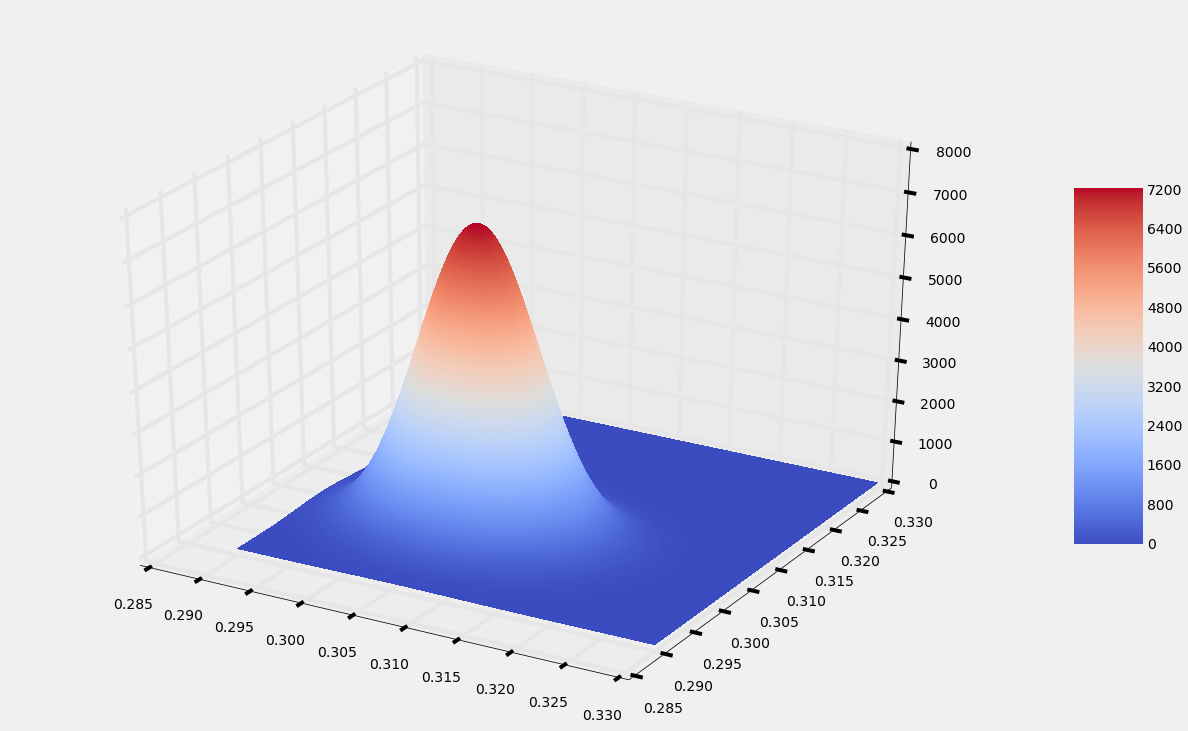

In [109]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# The chart above shows probability that Mike Piazza's batting average (x-axis) has value $x$ and Hank Aaron's batting average (y-axis) has value $y$

## What we want to do is solve for the area under the curve above where Mike Piazza's batting average is higher than Hank Aaron's

# Note: haven't figured this one out yet!!!!!!

In [117]:
list_of_vals = []

for x in np.linspace(0.29,0.33,100):
    for y in np.linspace(0.29,0.33,100):
        if x>y:
            val = beta.pdf(x, a_MP, b_MP)*beta.pdf(y, a_HA, b_HA)
            list_of_vals.append(val)
            
            
np.sum(list_of_vals)*(float(1)/(1000**2))

373.85675373605329

# 3. Closed-form solution

- We can desribe the Beta distributions for Mike Piazza and Hank Aaron as follows:

# $p_{MP} = \text{Beta}(\alpha_{MP}, \beta_{MP}) = \text{Beta}(2245, 5103)$
# $p_{HA} = \text{Beta}(\alpha_{HA}, \beta_{HA}) = \text{Beta}(3889, 8912)$

- From this, we can derive the probability that $p_{MP}>p_{HA}$ as:

# $P(p_{MP}>p_{HA}) = \sum^{\alpha_{MP}-1}_{i=0}\frac{[\text{B}(\alpha_{HA}+i, \beta_{MP}+\beta_{HA})]}{\beta_{MP}*\text{B}(1+i, \beta_{MP})*\text{B}(\alpha_{HA}, \beta_{HA})}$

## where $\text{B}$ is the Beta distribution i.e. $\text{B}(a, b) = \int_{0}^{1}t^{x-1}(1-t)^{y-1}dt$

In [241]:
def f(a1, b1, a2, b2):
    a1 = np.round(a1, 0)
    a2 = np.round(a2, 0)
    b1 = np.round(b1, 0)
    b2 = np.round(b2, 0)
    
    
    array = np.arange(0, a2-1)
    
    val_1 = np.log(special.beta(a1 + array, b1 + b2))
    val_2 = b2 + array
    val_3 = np.log(special.beta(1+array, b2))
    val_4 = np.log(special.beta(a1, b1))
    
    series = val_1/(val_2*val_3*val_4)
    
    return 1-(np.exp(series)).sum(), series

In [242]:
f(a_HA, b_HA, a_MP, b_MP)

(nan, array([ nan,  nan,  nan, ...,  nan,  nan,  nan]))

In [199]:
(special.gamma(a_HA)*special.gamma(b_HA))/special.gamma(a_HA+b_HA)

nan

In [198]:
np.prod(np.arange(1, a_MP-1))

inf

# Will figure this out later!!!!!!!!!!!!!!!!!!!!!!!!

# 4. Closed-form approximation

- When $\alpha$ and $\beta$ get pretty big, the Beta distribution can be accurately approximated by the Normal distribution

- Recall from [this site](https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance) that the mean and variance can be calculated as:

# $\mu = \frac{\alpha}{\alpha + \beta}$ ; $\sigma^{2} = \frac{\alpha\beta}{(\alpha + \beta + 1)(\alpha + \beta)^{2}}$

- Let's look at the Normal distributions for Hank and Mike and compare them to the Beta distributions

In [286]:
mu_mike = a_MP/(a_MP+b_MP)
mu_hank = a_HA/(a_HA+b_HA)

std_mike = np.sqrt((a_MP*b_MP)/((a_MP+b_MP+1)*(a_MP+b_MP)**2))
std_hank = np.sqrt((a_HA*b_HA)/((a_HA+b_HA+1)*(a_HA+b_HA)**2))

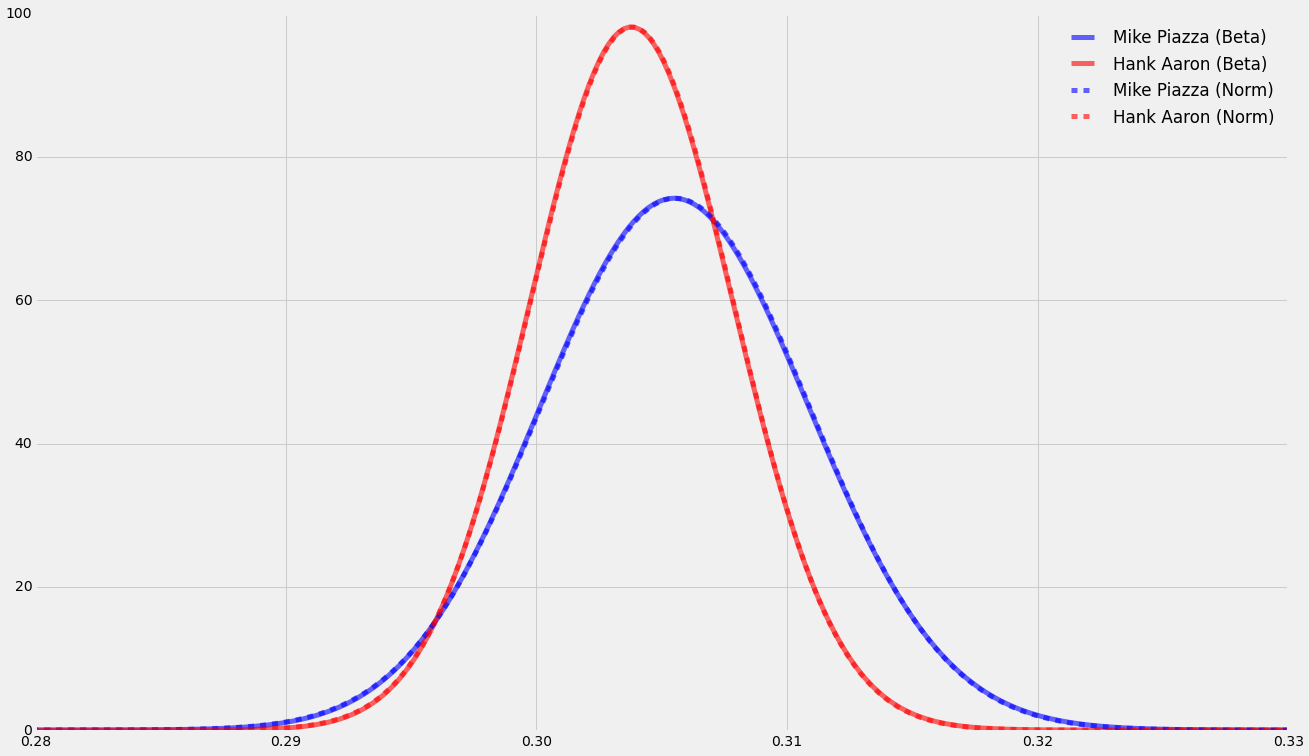

In [287]:
from scipy.stats import norm

x = np.linspace(0.2,0.4,1000)

plt.plot(x, beta.pdf(x, a_MP, b_MP),lw=5, alpha=0.6, color = 'b', label='Mike Piazza (Beta)')
plt.plot(x, beta.pdf(x, a_HA, b_HA),lw=5, alpha=0.6, color = 'r', label='Hank Aaron (Beta)')

plt.plot(x, norm.pdf(x, mu_mike, std_mike),lw=5, alpha=0.6, ls = 'dashed', color = 'b', label='Mike Piazza (Norm)')
plt.plot(x, norm.pdf(x, mu_hank, std_hank),lw=5, alpha=0.6, ls = 'dashed', color = 'r', label='Hank Aaron (Norm)')

plt.ylim([-0.1, 100])
plt.xlim([0.28, 0.33])
plt.legend()
plt.show()

# They look almost identical!

# Ultimately, what we want to know is: whose distribution shows better batting performance?

## Using our new Normal distributions, we can think of it as: whose cdf is more shifted to the right for a given batting average?

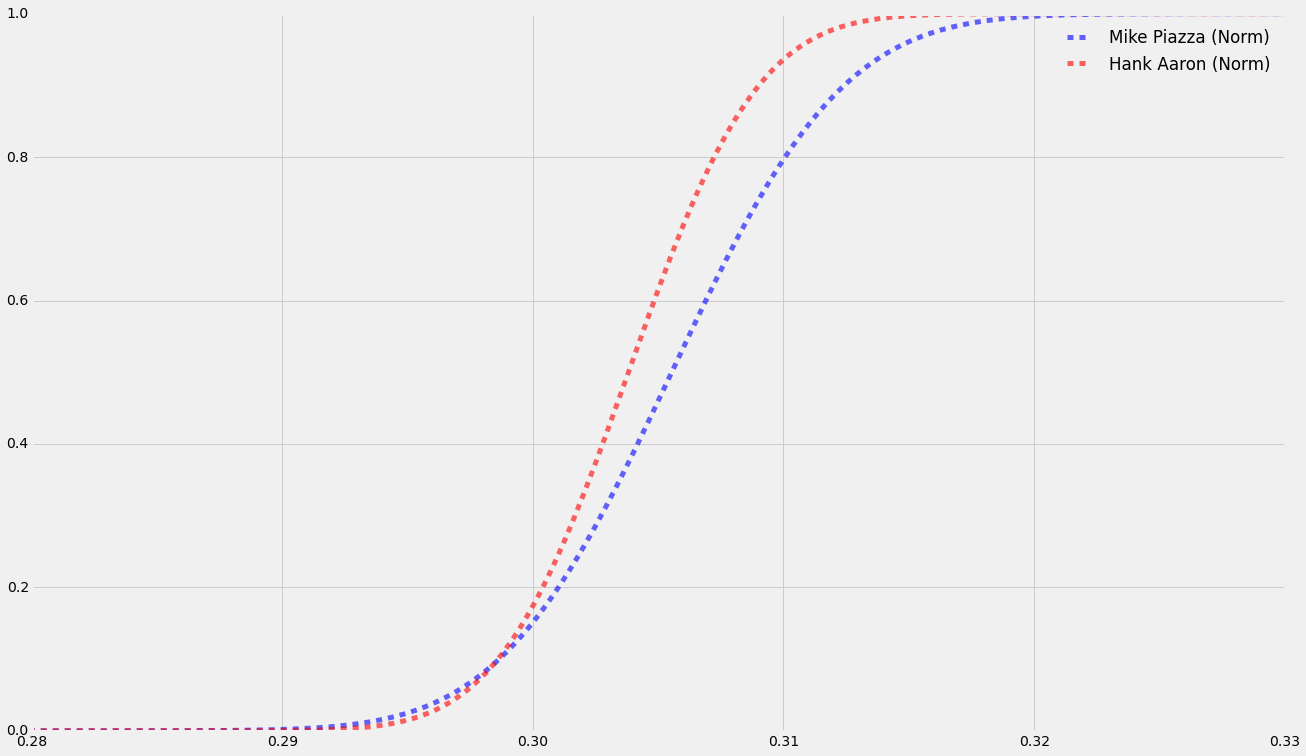

In [289]:
plt.plot(x, norm.cdf(x, mu_mike, std_mike),lw=5, alpha=0.6, ls = 'dashed', color = 'b', label='Mike Piazza (Norm)')
plt.plot(x, norm.cdf(x, mu_hank, std_hank),lw=5, alpha=0.6, ls = 'dashed', color = 'r', label='Hank Aaron (Norm)')

plt.xlim([0.28, 0.33])
plt.legend()
plt.show()

# So if we take Mike Piazza's normal distribution and subtract Hank Aaron's normal distribution, it will show us *how much better Mike Piazza's distribution is at every batting average*

### Recall from [here](http://mathworld.wolfram.com/NormalDifferenceDistribution.html) that if X and Y are normal distributions, then Z = X - Y has $\mu_{Z} = \mu_{X} - \mu_{Y}$ and $\sigma^{2}_{Z} = \sigma^{2}_{X} + \sigma^{2}_{Y}$

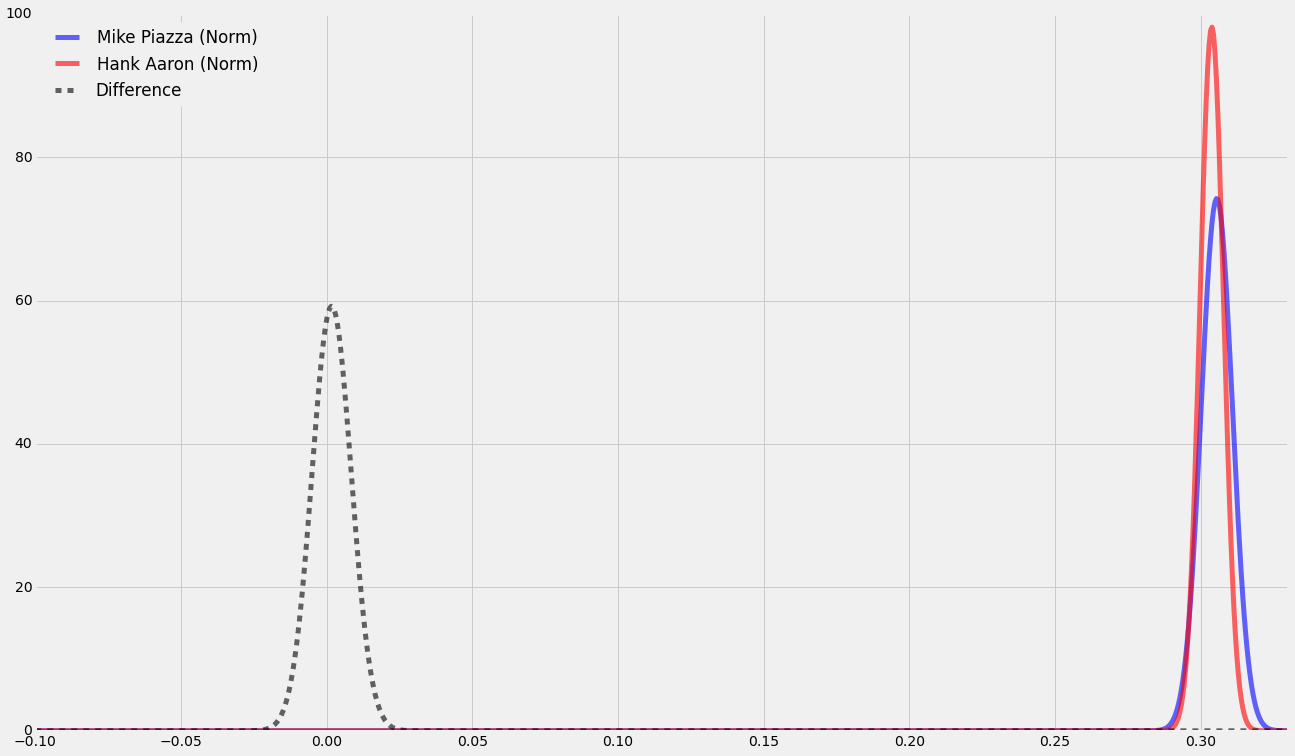

In [296]:
mu_difference = mu_mike - mu_hank
std_difference = np.sqrt(std_mike**2 + std_hank**2)

x = np.linspace(-0.1,0.4,1000)

plt.plot(x, norm.pdf(x, mu_mike, std_mike),lw=5, alpha=0.6, color = 'b', label='Mike Piazza (Norm)')
plt.plot(x, norm.pdf(x, mu_hank, std_hank),lw=5, alpha=0.6, color = 'r', label='Hank Aaron (Norm)')

plt.plot(x, norm.pdf(x, mu_difference, std_difference),lw=5, alpha=0.6, ls = 'dashed', color = 'k', label='Difference')

plt.xlim([-0.1, 0.33])
plt.legend(loc = 'upper left')
plt.show()

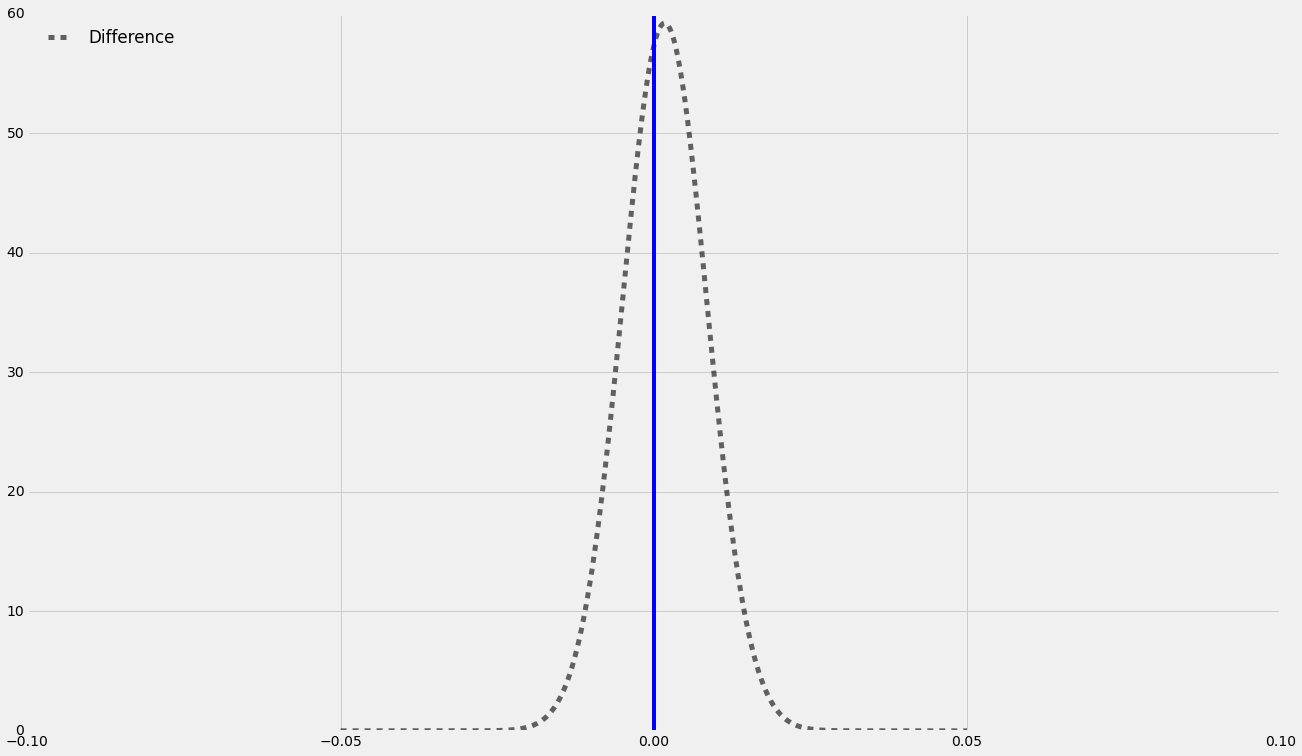

In [298]:
x = np.linspace(-0.05,0.05,1000)

plt.plot(x, norm.pdf(x, mu_difference, std_difference),lw=5, alpha=0.6, ls = 'dashed', color = 'k', label='Difference')
plt.axvline(0)
plt.xlim([-0.1, 0.1])
plt.legend(loc = 'upper left')
plt.show()

# We can see from the chart above that the Normal distribution for their two batting averages is shifted to the right

## If it was directly centered at 0, it would imply it's just as likely that either player is better

### If we compare the area under the curve to the left of 0 to the area under the curve to the right of 0, it's the same idea as 1. Simulation of posterior draws

In [299]:
auc_left = norm.cdf(0, mu_difference, std_difference)
auc_right = 1-norm.cdf(0, mu_difference, std_difference)
auc_left, auc_right

(0.39877521587240211, 0.60122478412759794)

# This approximation of 0.6012 is very close to our previously calculated value of 0.5998

____

# Now, we can extend credible intervals to our normal distribution for their difference

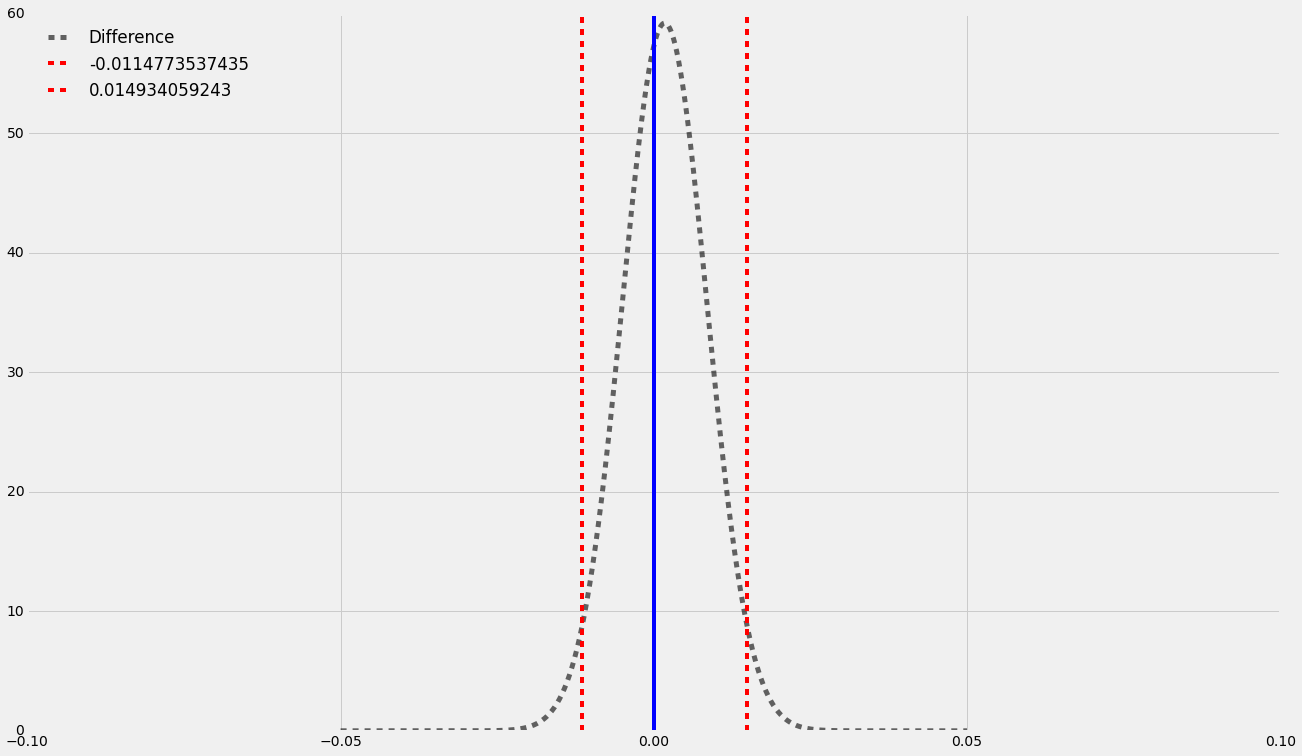

In [302]:
x = np.linspace(-0.05,0.05,1000)

plt.plot(x, norm.pdf(x, mu_difference, std_difference),lw=5, alpha=0.6, ls = 'dashed', color = 'k', label='Difference')
plt.axvline(0)

v_low = norm.ppf(0.025, mu_difference, std_difference)
v_high = norm.ppf(1-0.025, mu_difference, std_difference)

plt.axvline(0)
plt.axvline(v_low, ls = 'dashed', color = 'r', label = v_low)
plt.axvline(v_high, ls = 'dashed', color = 'r', label = v_high)

plt.xlim([-0.1, 0.1])
plt.legend(loc = 'upper left')
plt.show()